# 09. HNSCC patient scRNA-seq analysis

Samples were accessed through the [3CA database](https://www.weizmann.ac.il/sites/3CA/).

In [1]:
import scanpy as sc
import pandas as pd
from scipy import io
import os
from anndata import AnnData
import numpy as np
from matplotlib.pyplot import rc_context
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import matplotlib.pyplot as plt
import random
import scvi
from matplotlib import rc_context
import seaborn as sns

sc.set_figure_params(dpi_save = 600, fontsize = 12)

## 0. Read in data

In [167]:
# function that imports 3CA data and metadata, converts to AnnData object

def load_adata_from_directory(directory_path):
    
    # locate data
    mtx_candidates = ["Exp_data_UMIcounts.mtx", "Exp_data_TPM.mtx"]
    for name in mtx_candidates:
        mtx_path = os.path.join(directory_path, name)
        if os.path.exists(mtx_path):
            data_type = "TPM" if "TPM" in name else "UMI"
            break
    else:
        raise FileNotFoundError(f"No matrix file found in {directory_path}")

    # load other required files
    genes_path = os.path.join(directory_path, "Genes.txt")
    cells_path = os.path.join(directory_path, "Cells.csv")
    samples_path = os.path.join(directory_path, "Samples.csv")

    # load expression matrix and metadata
    X = io.mmread(mtx_path).T.tocsr()  # cells x genes
    var = pd.read_csv(genes_path, header=None, names=["gene_symbol"], sep="\t" if genes_path.endswith(".txt") else ",")
    obs = pd.read_csv(cells_path)

    # create AnnData
    adata = AnnData(X=X, obs=obs, var=var)
    adata.uns["data_type"] = data_type

    # add sample metadata
    if os.path.exists(samples_path):
        adata.uns['samples'] = pd.read_csv(samples_path)

    return adata

# base path and dataset directories
base_dir = "/path/to/Data_Head-and-Neck"
dataset_names = [
    "Data_Chen2020_Head-and-Neck",
    "Data_Kürten2021_Head-and-Neck"
]

adata_chen   = load_adata_from_directory(os.path.join(base_dir, "Data_Chen2020_Head-and-Neck"))
# Removed Cillo dataset because it only contains CD45+ cells
adata_kurten = load_adata_from_directory(os.path.join(base_dir, "Data_Kürten2021_Head-and-Neck"))

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [82]:
adata_chen.obs.index = adata_chen.obs['cell_name']
adata_chen.obs.drop(columns='cell_name', inplace=True)

adata_kurten.obs.index = adata_kurten.obs['cell_name']
adata_kurten.obs.drop(columns='cell_name', inplace=True)

In [81]:
adata_chen.var_names_make_unique()
adata_kurten.var_names_make_unique()

## 1. Perform pre-processing

In [84]:
# pre-processing function

def pp(adata):
    sc.pp.filter_genes(adata, min_cells=3)
    adata.var['MT'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
    adata.var['RB'] = adata.var_names.str.startswith(('RPS','RPL'))  # annotate the group of ribosomal proteins as 'rb'
    sc.pp.calculate_qc_metrics(adata, qc_vars=['MT'], percent_top=None, log1p=False, inplace=True)
    sc.pp.calculate_qc_metrics(adata, qc_vars=['RB'], percent_top=None, log1p=False, inplace=True)
    conditions = [
        (adata.obs['n_genes_by_counts'] < 500), # remove cells with fewer than 500 counts
        (adata.obs['pct_counts_MT'] > 25), # remove cells with greater than 25% mitochondrial counts
        (adata.obs['pct_counts_RB'] > 30), # remove cells with greater than 30% ribosomal counts
        (adata.obs['pct_counts_MT'] <= 25) & # criteria to keep cells
        (adata.obs['n_genes_by_counts'] >= 500) & 
        (adata.obs['pct_counts_RB'] <= 30)
    ]
    
    values = ['Low_nFeature', 'High_MT','High_RB', 'Pass']
    adata.obs['QC'] = np.select(conditions, values)
    adata.obs['QC'] = adata.obs['QC'].astype('category')
    adata.obs[['n_genes_by_counts','pct_counts_MT','QC']].head(10)
    adata_filt = adata[adata.obs['QC'] == 'Pass']
    print(adata.obs['QC'].value_counts())
    return(adata_filt)

In [85]:
# run pre-processing and report # of passing cells

adata_chen_pp  = pp(adata_chen)
adata_kurten_pp = pp(adata_kurten)

QC
Pass    71896
Name: count, dtype: int64
QC
Pass    62700
Name: count, dtype: int64
QC
Pass    5902
Name: count, dtype: int64


In [86]:
# scale to highly-variable genes

sc.pp.highly_variable_genes(adata_chen_pp, n_top_genes = 4000, subset = True, flavor = 'cell_ranger')
sc.pp.highly_variable_genes(adata_kurten_pp, n_top_genes = 4000, subset = True, flavor = 'cell_ranger')

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:693: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:693: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:693: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}


In [87]:
# set up and train scvi model

scvi.model.SCVI.setup_anndata(adata_chen_pp)
vae_chen = scvi.model.SCVI(adata_chen_pp)
vae_chen.train()

scvi.model.SCVI.setup_anndata(adata_kurten_pp)
vae_kurten = scvi.model.SCVI(adata_kurten_pp)
vae_kurten.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 111/111: 100%|█| 111/111 [42:34<00:00, 23.41s/it, v_num=1, train_loss_step

`Trainer.fit` stopped: `max_epochs=111` reached.


Epoch 111/111: 100%|█| 111/111 [42:34<00:00, 23.02s/it, v_num=1, train_loss_step

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.



Epoch 128/128: 100%|█| 128/128 [44:49<00:00, 21.75s/it, v_num=1, train_loss_step

`Trainer.fit` stopped: `max_epochs=128` reached.


Epoch 128/128: 100%|█| 128/128 [44:49<00:00, 21.01s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.



Epoch 1/400:   0%|                                      | 0/400 [00:00<?, ?it/s]

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 2/400:   0%| | 1/400 [00:02<13:51,  2.08s/it, v_num=1, train_loss_step=4.5

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 3/400:   0%| | 2/400 [00:04<13:50,  2.09s/it, v_num=1, train_loss_step=3.8

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 4/400:   1%| | 3/400 [00:06<13:40,  2.07s/it, v_num=1, train_loss_step=3.8

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 5/400:   1%| | 4/400 [00:08<13:36,  2.06s/it, v_num=1, train_loss_step=3.7

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 6/400:   1%| | 5/400 [00:10<13:33,  2.06s/it, v_num=1, train_loss_step=3.5

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 7/400:   2%| | 6/400 [00:12<13:32,  2.06s/it, v_num=1, train_loss_step=3.6

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 8/400:   2%| | 7/400 [00:14<13:29,  2.06s/it, v_num=1, train_loss_step=3.5

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 9/400:   2%| | 8/400 [00:16<13:23,  2.05s/it, v_num=1, train_loss_step=3.4

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 10/400:   2%| | 9/400 [00:18<13:22,  2.05s/it, v_num=1, train_loss_step=3.

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 11/400:   2%| | 10/400 [00:20<13:29,  2.07s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 12/400:   3%| | 11/400 [00:22<13:34,  2.09s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 13/400:   3%| | 12/400 [00:24<13:37,  2.11s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 14/400:   3%| | 13/400 [00:27<13:31,  2.10s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 15/400:   4%| | 14/400 [00:29<13:34,  2.11s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 16/400:   4%| | 15/400 [00:31<13:21,  2.08s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 17/400:   4%| | 16/400 [00:33<13:11,  2.06s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 18/400:   4%| | 17/400 [00:35<13:01,  2.04s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 19/400:   4%| | 18/400 [00:37<13:01,  2.05s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 20/400:   5%| | 19/400 [00:39<12:58,  2.04s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 21/400:   5%| | 20/400 [00:41<12:57,  2.05s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 22/400:   5%| | 21/400 [00:43<12:56,  2.05s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 23/400:   6%| | 22/400 [00:45<13:08,  2.09s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 24/400:   6%| | 23/400 [00:47<13:06,  2.09s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 25/400:   6%| | 24/400 [00:49<13:03,  2.08s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 26/400:   6%| | 25/400 [00:51<13:01,  2.08s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 27/400:   6%| | 26/400 [00:53<13:09,  2.11s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 28/400:   7%| | 27/400 [00:56<13:06,  2.11s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 29/400:   7%| | 28/400 [00:58<13:05,  2.11s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 30/400:   7%| | 29/400 [01:00<13:04,  2.11s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 31/400:   8%| | 30/400 [01:02<12:53,  2.09s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 32/400:   8%| | 31/400 [01:04<12:52,  2.09s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 33/400:   8%| | 32/400 [01:06<12:47,  2.09s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 34/400:   8%| | 33/400 [01:08<12:35,  2.06s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 35/400:   8%| | 34/400 [01:10<12:34,  2.06s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 36/400:   9%| | 35/400 [01:12<12:27,  2.05s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 37/400:   9%| | 36/400 [01:14<12:30,  2.06s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 38/400:   9%| | 37/400 [01:16<12:26,  2.06s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 39/400:  10%| | 38/400 [01:18<12:23,  2.06s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 40/400:  10%| | 39/400 [01:20<12:27,  2.07s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 41/400:  10%| | 40/400 [01:22<12:24,  2.07s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 42/400:  10%| | 41/400 [01:24<12:19,  2.06s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 43/400:  10%| | 42/400 [01:27<12:16,  2.06s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 44/400:  11%| | 43/400 [01:29<12:09,  2.04s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 45/400:  11%| | 44/400 [01:31<12:06,  2.04s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 46/400:  11%| | 45/400 [01:33<12:15,  2.07s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 47/400:  12%| | 46/400 [01:35<12:16,  2.08s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 48/400:  12%| | 47/400 [01:37<12:31,  2.13s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 49/400:  12%| | 48/400 [01:39<12:22,  2.11s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 50/400:  12%| | 49/400 [01:41<12:24,  2.12s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 51/400:  12%|▏| 50/400 [01:44<12:37,  2.16s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 52/400:  13%|▏| 51/400 [01:46<12:28,  2.15s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 53/400:  13%|▏| 52/400 [01:48<12:16,  2.12s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 54/400:  13%|▏| 53/400 [01:50<12:07,  2.10s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 55/400:  14%|▏| 54/400 [01:52<11:56,  2.07s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 56/400:  14%|▏| 55/400 [01:54<11:54,  2.07s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 57/400:  14%|▏| 56/400 [01:56<11:53,  2.07s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 58/400:  14%|▏| 57/400 [01:58<12:06,  2.12s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 59/400:  14%|▏| 58/400 [02:00<12:04,  2.12s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 60/400:  15%|▏| 59/400 [02:02<12:00,  2.11s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 61/400:  15%|▏| 60/400 [02:04<12:00,  2.12s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 62/400:  15%|▏| 61/400 [02:07<11:58,  2.12s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 63/400:  16%|▏| 62/400 [02:09<11:56,  2.12s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 64/400:  16%|▏| 63/400 [02:11<11:51,  2.11s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 65/400:  16%|▏| 64/400 [02:13<11:44,  2.10s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 66/400:  16%|▏| 65/400 [02:15<11:46,  2.11s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 67/400:  16%|▏| 66/400 [02:17<11:42,  2.10s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 68/400:  17%|▏| 67/400 [02:19<11:39,  2.10s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 69/400:  17%|▏| 68/400 [02:21<11:39,  2.11s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 70/400:  17%|▏| 69/400 [02:23<11:38,  2.11s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 71/400:  18%|▏| 70/400 [02:26<11:36,  2.11s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 72/400:  18%|▏| 71/400 [02:28<11:35,  2.11s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 73/400:  18%|▏| 72/400 [02:30<11:32,  2.11s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 74/400:  18%|▏| 73/400 [02:32<11:29,  2.11s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 75/400:  18%|▏| 74/400 [02:34<11:22,  2.09s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 76/400:  19%|▏| 75/400 [02:36<11:32,  2.13s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 77/400:  19%|▏| 76/400 [02:38<11:33,  2.14s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 78/400:  19%|▏| 77/400 [02:40<11:24,  2.12s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 79/400:  20%|▏| 78/400 [02:42<11:17,  2.10s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 80/400:  20%|▏| 79/400 [02:45<11:15,  2.10s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 81/400:  20%|▏| 80/400 [02:47<11:11,  2.10s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 82/400:  20%|▏| 81/400 [02:49<11:06,  2.09s/it, v_num=1, train_loss_step=2

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 83/400:  20%|▏| 82/400 [02:51<11:08,  2.10s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 84/400:  21%|▏| 83/400 [02:53<11:06,  2.10s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 85/400:  21%|▏| 84/400 [02:55<10:59,  2.09s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 86/400:  21%|▏| 85/400 [02:57<10:58,  2.09s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 87/400:  22%|▏| 86/400 [02:59<10:49,  2.07s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 88/400:  22%|▏| 87/400 [03:01<10:43,  2.06s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 89/400:  22%|▏| 88/400 [03:03<10:40,  2.05s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 90/400:  22%|▏| 89/400 [03:05<10:48,  2.09s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 91/400:  22%|▏| 90/400 [03:07<10:48,  2.09s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 92/400:  23%|▏| 91/400 [03:10<10:43,  2.08s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 93/400:  23%|▏| 92/400 [03:12<10:43,  2.09s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 94/400:  23%|▏| 93/400 [03:14<10:41,  2.09s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 95/400:  24%|▏| 94/400 [03:16<10:37,  2.08s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 96/400:  24%|▏| 95/400 [03:18<10:36,  2.09s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 97/400:  24%|▏| 96/400 [03:20<10:27,  2.06s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 98/400:  24%|▏| 97/400 [03:22<10:22,  2.06s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 99/400:  24%|▏| 98/400 [03:24<10:29,  2.08s/it, v_num=1, train_loss_step=3

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 100/400:  25%|▏| 99/400 [03:26<10:37,  2.12s/it, v_num=1, train_loss_step=

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 101/400:  25%|▎| 100/400 [03:28<10:37,  2.13s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 102/400:  25%|▎| 101/400 [03:31<10:32,  2.12s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 103/400:  26%|▎| 102/400 [03:33<10:26,  2.10s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 104/400:  26%|▎| 103/400 [03:35<10:37,  2.15s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 105/400:  26%|▎| 104/400 [03:37<10:27,  2.12s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 106/400:  26%|▎| 105/400 [03:39<10:28,  2.13s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 107/400:  26%|▎| 106/400 [03:41<10:21,  2.11s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 108/400:  27%|▎| 107/400 [03:43<10:12,  2.09s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 109/400:  27%|▎| 108/400 [03:45<10:07,  2.08s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 110/400:  27%|▎| 109/400 [03:47<10:09,  2.10s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 111/400:  28%|▎| 110/400 [03:49<10:09,  2.10s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 112/400:  28%|▎| 111/400 [03:52<10:08,  2.10s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 113/400:  28%|▎| 112/400 [03:54<10:11,  2.12s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 114/400:  28%|▎| 113/400 [03:56<10:15,  2.14s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 115/400:  28%|▎| 114/400 [03:58<10:13,  2.14s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 116/400:  29%|▎| 115/400 [04:00<10:06,  2.13s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 117/400:  29%|▎| 116/400 [04:02<10:01,  2.12s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 118/400:  29%|▎| 117/400 [04:04<09:55,  2.10s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 119/400:  30%|▎| 118/400 [04:06<09:50,  2.10s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 120/400:  30%|▎| 119/400 [04:08<09:46,  2.09s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 121/400:  30%|▎| 120/400 [04:11<09:41,  2.08s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 122/400:  30%|▎| 121/400 [04:13<09:35,  2.06s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 123/400:  30%|▎| 122/400 [04:15<09:30,  2.05s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 124/400:  31%|▎| 123/400 [04:17<09:27,  2.05s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 125/400:  31%|▎| 124/400 [04:19<09:25,  2.05s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 126/400:  31%|▎| 125/400 [04:21<09:20,  2.04s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 127/400:  32%|▎| 126/400 [04:23<09:24,  2.06s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 128/400:  32%|▎| 127/400 [04:25<09:28,  2.08s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 129/400:  32%|▎| 128/400 [04:27<09:29,  2.09s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 130/400:  32%|▎| 129/400 [04:29<09:38,  2.13s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 131/400:  32%|▎| 130/400 [04:31<09:30,  2.11s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 132/400:  33%|▎| 131/400 [04:34<09:32,  2.13s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 133/400:  33%|▎| 132/400 [04:36<09:28,  2.12s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 134/400:  33%|▎| 133/400 [04:38<09:26,  2.12s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 135/400:  34%|▎| 134/400 [04:40<09:24,  2.12s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 136/400:  34%|▎| 135/400 [04:42<09:21,  2.12s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 137/400:  34%|▎| 136/400 [04:44<09:20,  2.12s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 138/400:  34%|▎| 137/400 [04:46<09:18,  2.12s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 139/400:  34%|▎| 138/400 [04:48<09:14,  2.11s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 140/400:  35%|▎| 139/400 [04:50<09:11,  2.11s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 141/400:  35%|▎| 140/400 [04:52<09:05,  2.10s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 142/400:  35%|▎| 141/400 [04:55<09:07,  2.11s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 143/400:  36%|▎| 142/400 [04:57<09:09,  2.13s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 144/400:  36%|▎| 143/400 [04:59<09:04,  2.12s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 145/400:  36%|▎| 144/400 [05:01<08:58,  2.10s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 146/400:  36%|▎| 145/400 [05:03<08:56,  2.11s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 147/400:  36%|▎| 146/400 [05:05<08:51,  2.09s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 148/400:  37%|▎| 147/400 [05:07<08:49,  2.09s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 149/400:  37%|▎| 148/400 [05:09<08:50,  2.10s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 150/400:  37%|▎| 149/400 [05:12<08:50,  2.11s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 151/400:  38%|▍| 150/400 [05:14<08:46,  2.11s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 152/400:  38%|▍| 151/400 [05:16<08:41,  2.09s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 153/400:  38%|▍| 152/400 [05:18<08:41,  2.10s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 154/400:  38%|▍| 153/400 [05:20<08:36,  2.09s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 155/400:  38%|▍| 154/400 [05:22<08:50,  2.16s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 156/400:  39%|▍| 155/400 [05:24<08:45,  2.15s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 157/400:  39%|▍| 156/400 [05:26<08:40,  2.13s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 158/400:  39%|▍| 157/400 [05:29<08:40,  2.14s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 159/400:  40%|▍| 158/400 [05:31<08:37,  2.14s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 160/400:  40%|▍| 159/400 [05:33<08:30,  2.12s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 161/400:  40%|▍| 160/400 [05:35<08:28,  2.12s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 162/400:  40%|▍| 161/400 [05:37<08:27,  2.12s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 163/400:  40%|▍| 162/400 [05:39<08:22,  2.11s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 164/400:  41%|▍| 163/400 [05:41<08:21,  2.12s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 165/400:  41%|▍| 164/400 [05:43<08:18,  2.11s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 166/400:  41%|▍| 165/400 [05:45<08:13,  2.10s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 167/400:  42%|▍| 166/400 [05:48<08:24,  2.15s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 168/400:  42%|▍| 167/400 [05:50<08:21,  2.15s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 169/400:  42%|▍| 168/400 [05:52<08:20,  2.16s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 170/400:  42%|▍| 169/400 [05:54<08:15,  2.15s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 171/400:  42%|▍| 170/400 [05:56<08:09,  2.13s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 172/400:  43%|▍| 171/400 [05:58<08:07,  2.13s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 173/400:  43%|▍| 172/400 [06:00<07:55,  2.09s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 174/400:  43%|▍| 173/400 [06:02<07:51,  2.08s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 175/400:  44%|▍| 174/400 [06:04<07:45,  2.06s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 176/400:  44%|▍| 175/400 [06:06<07:45,  2.07s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 177/400:  44%|▍| 176/400 [06:09<07:50,  2.10s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 178/400:  44%|▍| 177/400 [06:11<07:47,  2.10s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 179/400:  44%|▍| 178/400 [06:13<07:49,  2.11s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 180/400:  45%|▍| 179/400 [06:15<07:51,  2.13s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 181/400:  45%|▍| 180/400 [06:17<07:47,  2.12s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 182/400:  45%|▍| 181/400 [06:19<07:46,  2.13s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 183/400:  46%|▍| 182/400 [06:21<07:43,  2.13s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 184/400:  46%|▍| 183/400 [06:24<07:40,  2.12s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 185/400:  46%|▍| 184/400 [06:26<07:36,  2.11s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 186/400:  46%|▍| 185/400 [06:28<07:29,  2.09s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 187/400:  46%|▍| 186/400 [06:30<07:34,  2.12s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 188/400:  47%|▍| 187/400 [06:32<07:27,  2.10s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 189/400:  47%|▍| 188/400 [06:34<07:24,  2.10s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 190/400:  47%|▍| 189/400 [06:36<07:24,  2.11s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 191/400:  48%|▍| 190/400 [06:38<07:20,  2.10s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 192/400:  48%|▍| 191/400 [06:40<07:22,  2.12s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 193/400:  48%|▍| 192/400 [06:42<07:19,  2.11s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 194/400:  48%|▍| 193/400 [06:45<07:18,  2.12s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 195/400:  48%|▍| 194/400 [06:47<07:17,  2.13s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 196/400:  49%|▍| 195/400 [06:49<07:08,  2.09s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 197/400:  49%|▍| 196/400 [06:51<07:02,  2.07s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 198/400:  49%|▍| 197/400 [06:53<07:04,  2.09s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 199/400:  50%|▍| 198/400 [06:55<07:07,  2.12s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 200/400:  50%|▍| 199/400 [06:57<07:09,  2.14s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 201/400:  50%|▌| 200/400 [06:59<07:05,  2.13s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 202/400:  50%|▌| 201/400 [07:02<07:04,  2.13s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 203/400:  50%|▌| 202/400 [07:04<07:05,  2.15s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 204/400:  51%|▌| 203/400 [07:06<07:01,  2.14s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 205/400:  51%|▌| 204/400 [07:08<06:56,  2.12s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 206/400:  51%|▌| 205/400 [07:10<06:49,  2.10s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 207/400:  52%|▌| 206/400 [07:12<06:44,  2.08s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 208/400:  52%|▌| 207/400 [07:14<06:43,  2.09s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 209/400:  52%|▌| 208/400 [07:16<06:41,  2.09s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 210/400:  52%|▌| 209/400 [07:18<06:40,  2.10s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 211/400:  52%|▌| 210/400 [07:20<06:41,  2.11s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 212/400:  53%|▌| 211/400 [07:23<06:39,  2.12s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 213/400:  53%|▌| 212/400 [07:25<06:38,  2.12s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 214/400:  53%|▌| 213/400 [07:27<06:33,  2.10s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 215/400:  54%|▌| 214/400 [07:29<06:29,  2.10s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 216/400:  54%|▌| 215/400 [07:31<06:29,  2.11s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 217/400:  54%|▌| 216/400 [07:33<06:27,  2.11s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 218/400:  54%|▌| 217/400 [07:35<06:22,  2.09s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 219/400:  55%|▌| 218/400 [07:37<06:20,  2.09s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 220/400:  55%|▌| 219/400 [07:39<06:18,  2.09s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 221/400:  55%|▌| 220/400 [07:41<06:19,  2.11s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 222/400:  55%|▌| 221/400 [07:44<06:18,  2.12s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 223/400:  56%|▌| 222/400 [07:46<06:18,  2.13s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 224/400:  56%|▌| 223/400 [07:48<06:17,  2.14s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 225/400:  56%|▌| 224/400 [07:50<06:14,  2.13s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 226/400:  56%|▌| 225/400 [07:52<06:14,  2.14s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 227/400:  56%|▌| 226/400 [07:54<06:15,  2.16s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 228/400:  57%|▌| 227/400 [07:57<06:13,  2.16s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 229/400:  57%|▌| 228/400 [07:59<06:06,  2.13s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 230/400:  57%|▌| 229/400 [08:01<06:04,  2.13s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 231/400:  57%|▌| 230/400 [08:03<06:02,  2.13s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 232/400:  58%|▌| 231/400 [08:05<06:03,  2.15s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 233/400:  58%|▌| 232/400 [08:07<06:02,  2.16s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 234/400:  58%|▌| 233/400 [08:09<05:58,  2.15s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 235/400:  58%|▌| 234/400 [08:12<05:56,  2.15s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 236/400:  59%|▌| 235/400 [08:14<05:52,  2.14s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 237/400:  59%|▌| 236/400 [08:16<05:53,  2.15s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 238/400:  59%|▌| 237/400 [08:18<05:47,  2.13s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 239/400:  60%|▌| 238/400 [08:20<05:45,  2.13s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 240/400:  60%|▌| 239/400 [08:22<05:42,  2.13s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 241/400:  60%|▌| 240/400 [08:24<05:39,  2.12s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 242/400:  60%|▌| 241/400 [08:27<05:59,  2.26s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 243/400:  60%|▌| 242/400 [08:31<07:45,  2.95s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 244/400:  61%|▌| 243/400 [08:36<09:00,  3.44s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 245/400:  61%|▌| 244/400 [08:39<08:57,  3.45s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 246/400:  61%|▌| 245/400 [08:43<08:34,  3.32s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 247/400:  62%|▌| 246/400 [08:45<08:00,  3.12s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 248/400:  62%|▌| 247/400 [08:48<07:26,  2.92s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 249/400:  62%|▌| 248/400 [08:50<06:54,  2.73s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 250/400:  62%|▌| 249/400 [08:52<06:29,  2.58s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 251/400:  62%|▋| 250/400 [08:55<06:22,  2.55s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 252/400:  63%|▋| 251/400 [08:57<06:06,  2.46s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 253/400:  63%|▋| 252/400 [08:59<05:57,  2.41s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 254/400:  63%|▋| 253/400 [09:02<05:53,  2.41s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 255/400:  64%|▋| 254/400 [09:04<05:54,  2.43s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 256/400:  64%|▋| 255/400 [09:07<05:57,  2.46s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 257/400:  64%|▋| 256/400 [09:09<05:58,  2.49s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 258/400:  64%|▋| 257/400 [09:12<05:53,  2.47s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 259/400:  64%|▋| 258/400 [09:14<05:45,  2.43s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 260/400:  65%|▋| 259/400 [09:16<05:42,  2.43s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 261/400:  65%|▋| 260/400 [09:19<05:37,  2.41s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 262/400:  65%|▋| 261/400 [09:21<05:37,  2.43s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 263/400:  66%|▋| 262/400 [09:24<05:37,  2.44s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 264/400:  66%|▋| 263/400 [09:26<05:46,  2.53s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 265/400:  66%|▋| 264/400 [09:29<06:04,  2.68s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 266/400:  66%|▋| 265/400 [09:32<06:14,  2.77s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 267/400:  66%|▋| 266/400 [09:35<06:18,  2.83s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 268/400:  67%|▋| 267/400 [09:38<06:13,  2.80s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 269/400:  67%|▋| 268/400 [09:40<05:52,  2.67s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 270/400:  67%|▋| 269/400 [09:43<05:35,  2.56s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 271/400:  68%|▋| 270/400 [09:45<05:20,  2.47s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 272/400:  68%|▋| 271/400 [09:47<05:15,  2.44s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 273/400:  68%|▋| 272/400 [09:50<05:11,  2.44s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 274/400:  68%|▋| 273/400 [09:52<05:06,  2.42s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 275/400:  68%|▋| 274/400 [09:55<05:03,  2.41s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 276/400:  69%|▋| 275/400 [09:57<05:03,  2.42s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 277/400:  69%|▋| 276/400 [09:59<04:58,  2.40s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 278/400:  69%|▋| 277/400 [10:02<04:52,  2.38s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 279/400:  70%|▋| 278/400 [10:04<04:53,  2.41s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 280/400:  70%|▋| 279/400 [10:07<04:52,  2.41s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 281/400:  70%|▋| 280/400 [10:09<05:01,  2.51s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 282/400:  70%|▋| 281/400 [10:12<05:03,  2.55s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 283/400:  70%|▋| 282/400 [10:15<05:05,  2.59s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 284/400:  71%|▋| 283/400 [10:17<05:03,  2.59s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 285/400:  71%|▋| 284/400 [10:20<05:03,  2.62s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 286/400:  71%|▋| 285/400 [10:23<05:13,  2.73s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 287/400:  72%|▋| 286/400 [10:26<05:22,  2.82s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 288/400:  72%|▋| 287/400 [10:29<05:22,  2.86s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 289/400:  72%|▋| 288/400 [10:32<05:16,  2.83s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 290/400:  72%|▋| 289/400 [10:35<05:14,  2.83s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 291/400:  72%|▋| 290/400 [10:37<05:04,  2.77s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 292/400:  73%|▋| 291/400 [10:40<04:50,  2.66s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 293/400:  73%|▋| 292/400 [10:42<04:39,  2.59s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 294/400:  73%|▋| 293/400 [10:44<04:33,  2.56s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 295/400:  74%|▋| 294/400 [10:47<04:27,  2.53s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 296/400:  74%|▋| 295/400 [10:49<04:19,  2.47s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 297/400:  74%|▋| 296/400 [10:52<04:12,  2.43s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 298/400:  74%|▋| 297/400 [10:54<04:08,  2.41s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 299/400:  74%|▋| 298/400 [10:56<04:07,  2.43s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 300/400:  75%|▋| 299/400 [10:59<04:00,  2.39s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 301/400:  75%|▊| 300/400 [11:01<03:54,  2.34s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 302/400:  75%|▊| 301/400 [11:03<03:51,  2.34s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 303/400:  76%|▊| 302/400 [11:06<03:54,  2.39s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 304/400:  76%|▊| 303/400 [11:08<03:53,  2.41s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 305/400:  76%|▊| 304/400 [11:11<03:56,  2.46s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 306/400:  76%|▊| 305/400 [11:13<03:56,  2.49s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 307/400:  76%|▊| 306/400 [11:16<03:55,  2.51s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 308/400:  77%|▊| 307/400 [11:19<03:54,  2.52s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 309/400:  77%|▊| 308/400 [11:21<03:47,  2.48s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 310/400:  77%|▊| 309/400 [11:23<03:41,  2.44s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 311/400:  78%|▊| 310/400 [11:25<03:34,  2.38s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 312/400:  78%|▊| 311/400 [11:28<03:29,  2.35s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 313/400:  78%|▊| 312/400 [11:30<03:23,  2.31s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 314/400:  78%|▊| 313/400 [11:32<03:21,  2.31s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 315/400:  78%|▊| 314/400 [11:35<03:17,  2.29s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 316/400:  79%|▊| 315/400 [11:37<03:12,  2.27s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 317/400:  79%|▊| 316/400 [11:39<03:10,  2.27s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 318/400:  79%|▊| 317/400 [11:41<03:07,  2.26s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 319/400:  80%|▊| 318/400 [11:44<03:07,  2.28s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 320/400:  80%|▊| 319/400 [11:46<03:06,  2.30s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 321/400:  80%|▊| 320/400 [11:48<03:03,  2.29s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 322/400:  80%|▊| 321/400 [11:50<02:59,  2.28s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 323/400:  80%|▊| 322/400 [11:53<02:59,  2.30s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 324/400:  81%|▊| 323/400 [11:55<03:03,  2.38s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 325/400:  81%|▊| 324/400 [11:58<03:06,  2.45s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 326/400:  81%|▊| 325/400 [12:01<03:07,  2.50s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 327/400:  82%|▊| 326/400 [12:03<03:09,  2.56s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 328/400:  82%|▊| 327/400 [12:06<03:09,  2.59s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 329/400:  82%|▊| 328/400 [12:09<03:07,  2.60s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 330/400:  82%|▊| 329/400 [12:11<03:00,  2.54s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 331/400:  82%|▊| 330/400 [12:13<02:52,  2.47s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 332/400:  83%|▊| 331/400 [12:16<02:47,  2.42s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 333/400:  83%|▊| 332/400 [12:18<02:42,  2.40s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 334/400:  83%|▊| 333/400 [12:20<02:40,  2.40s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 335/400:  84%|▊| 334/400 [12:23<02:41,  2.45s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 336/400:  84%|▊| 335/400 [12:25<02:40,  2.47s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 337/400:  84%|▊| 336/400 [12:28<02:37,  2.46s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 338/400:  84%|▊| 337/400 [12:30<02:35,  2.47s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 339/400:  84%|▊| 338/400 [12:33<02:36,  2.52s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 340/400:  85%|▊| 339/400 [12:35<02:33,  2.51s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 341/400:  85%|▊| 340/400 [12:38<02:34,  2.57s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 342/400:  85%|▊| 341/400 [12:41<02:30,  2.55s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 343/400:  86%|▊| 342/400 [12:43<02:27,  2.55s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 344/400:  86%|▊| 343/400 [12:46<02:25,  2.56s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 345/400:  86%|▊| 344/400 [12:48<02:23,  2.56s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 346/400:  86%|▊| 345/400 [12:51<02:23,  2.61s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 347/400:  86%|▊| 346/400 [12:54<02:22,  2.65s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 348/400:  87%|▊| 347/400 [12:56<02:20,  2.65s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 349/400:  87%|▊| 348/400 [12:59<02:17,  2.65s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 350/400:  87%|▊| 349/400 [13:02<02:12,  2.59s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 351/400:  88%|▉| 350/400 [13:05<02:21,  2.83s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 352/400:  88%|▉| 351/400 [13:07<02:13,  2.73s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 353/400:  88%|▉| 352/400 [13:10<02:06,  2.64s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 354/400:  88%|▉| 353/400 [13:12<01:59,  2.54s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 355/400:  88%|▉| 354/400 [13:14<01:53,  2.46s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 356/400:  89%|▉| 355/400 [13:17<01:48,  2.42s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 357/400:  89%|▉| 356/400 [13:19<01:44,  2.37s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 358/400:  89%|▉| 357/400 [13:21<01:39,  2.32s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 359/400:  90%|▉| 358/400 [13:24<01:36,  2.31s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 360/400:  90%|▉| 359/400 [13:26<01:33,  2.29s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 361/400:  90%|▉| 360/400 [13:28<01:30,  2.27s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 362/400:  90%|▉| 361/400 [13:30<01:28,  2.27s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 363/400:  90%|▉| 362/400 [13:33<01:27,  2.30s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 364/400:  91%|▉| 363/400 [13:35<01:30,  2.45s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 365/400:  91%|▉| 364/400 [13:38<01:34,  2.62s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 366/400:  91%|▉| 365/400 [13:41<01:35,  2.74s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 367/400:  92%|▉| 366/400 [13:44<01:33,  2.74s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 368/400:  92%|▉| 367/400 [13:47<01:31,  2.77s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 369/400:  92%|▉| 368/400 [13:50<01:28,  2.78s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 370/400:  92%|▉| 369/400 [13:52<01:23,  2.70s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 371/400:  92%|▉| 370/400 [13:55<01:17,  2.60s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 372/400:  93%|▉| 371/400 [13:57<01:12,  2.52s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 373/400:  93%|▉| 372/400 [13:59<01:08,  2.45s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 374/400:  93%|▉| 373/400 [14:02<01:04,  2.40s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 375/400:  94%|▉| 374/400 [14:04<01:01,  2.37s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 376/400:  94%|▉| 375/400 [14:06<00:58,  2.35s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 377/400:  94%|▉| 376/400 [14:09<00:55,  2.33s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 378/400:  94%|▉| 377/400 [14:11<00:53,  2.31s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 379/400:  94%|▉| 378/400 [14:13<00:50,  2.30s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 380/400:  95%|▉| 379/400 [14:15<00:48,  2.30s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 381/400:  95%|▉| 380/400 [14:18<00:45,  2.29s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 382/400:  95%|▉| 381/400 [14:20<00:43,  2.29s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 383/400:  96%|▉| 382/400 [14:22<00:41,  2.29s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 384/400:  96%|▉| 383/400 [14:25<00:39,  2.33s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 385/400:  96%|▉| 384/400 [14:27<00:38,  2.40s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 386/400:  96%|▉| 385/400 [14:30<00:37,  2.47s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 387/400:  96%|▉| 386/400 [14:33<00:35,  2.55s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 388/400:  97%|▉| 387/400 [14:36<00:34,  2.69s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 389/400:  97%|▉| 388/400 [14:39<00:33,  2.80s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 390/400:  97%|▉| 389/400 [14:41<00:30,  2.78s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 391/400:  98%|▉| 390/400 [14:44<00:27,  2.70s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 392/400:  98%|▉| 391/400 [14:47<00:25,  2.81s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 393/400:  98%|▉| 392/400 [14:50<00:22,  2.86s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 394/400:  98%|▉| 393/400 [14:52<00:19,  2.75s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 395/400:  98%|▉| 394/400 [14:55<00:15,  2.64s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 396/400:  99%|▉| 395/400 [14:57<00:12,  2.53s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 397/400:  99%|▉| 396/400 [14:59<00:09,  2.45s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 398/400:  99%|▉| 397/400 [15:02<00:07,  2.40s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 399/400: 100%|▉| 398/400 [15:04<00:04,  2.37s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 400/400: 100%|▉| 399/400 [15:06<00:02,  2.35s/it, v_num=1, train_loss_step

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 400/400: 100%|█| 400/400 [15:08<00:00,  2.31s/it, v_num=1, train_loss_step

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█| 400/400 [15:08<00:00,  2.27s/it, v_num=1, train_loss_step


In [88]:
# begin doublet detection
# initiate SOLO model from pre-trained scvi model

solo_chen = scvi.external.SOLO.from_scvi_model(vae_chen)
solo_chen.train()

solo_kurten = scvi.external.SOLO.from_scvi_model(vae_kurten)
solo_kurten.train()

INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 116/400:  29%|▎| 116/400 [06:26<15:45,  3.33s/it, v_num=1, train_loss_step
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.121. Signaling Trainer to stop.
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 232/400:  58%|▌| 232/400 [11:06<08:02,  2.87s/it, v_num=1, train_loss_step
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.177. Signaling Trainer to stop.
INFO     Creating doublets, preparing SOLO model.                                                                  


/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader`

Epoch 132/400:  33%|▎| 132/400 [00:37<01:15,  3.57it/s, v_num=1, train_loss_step
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.001. Signaling Trainer to stop.


In [89]:
# predict doublets and store as dataframe 

df_chen = solo_chen.predict()
df_chen['prediction'] = solo_chen.predict(soft = False)
df_chen.index = df_chen.index.map(lambda x: x[:-2])
print(len(df_chen[df_chen.prediction == 'doublet']))
df_chen.rename(lambda x: str(x) + '-1', inplace=True)
df_chen

df_kurten = solo_kurten.predict()
df_kurten['prediction'] = solo_kurten.predict(soft = False)
df_kurten.index = df_kurten.index.map(lambda x: x[:-2])
print(len(df_kurten[df_kurten.prediction == 'doublet']))
df_kurten.rename(lambda x: str(x) + '-1', inplace=True)
df_kurten

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)


6829


/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)


7749
0


/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)


doublet   singlet prediction
HN28_P15_D06_S330_co-1     1.606095e-04  0.999839    singlet
HN28_P6_G05_S173_co-1      3.767673e-08  1.000000    singlet
HN26_P14_D11_S239_co-1     3.376591e-06  0.999997    singlet
HN26_P14_H05_S281_co-1     1.217208e-07  1.000000    singlet
HN26_P25_H09_S189_co-1     4.452102e-05  0.999956    singlet
...                                 ...       ...        ...
HNSCC17_P4_G12_S180_co-1   1.906961e-09  1.000000    singlet
HNSCC20_P13_C05_S221_co-1  2.270181e-09  1.000000    singlet
HNSCC17_P4_C12_S132_co-1   7.141739e-10  1.000000    singlet
HNSCC20_P3_H08_S92_co-1    1.306324e-05  0.999987    singlet
HNSCC20_P3_G06_S78_co-1    3.850645e-07  1.000000    singlet

[5902 rows x 3 columns]

In [90]:
# plot doublets

def plot_doublets(adata_filt, df):
    adata_filt.obs['prediction'] = df.prediction
    sc.pp.normalize_total(adata_filt, target_sum = 1e4)
    sc.pp.log1p(adata_filt)
    adata_filt.raw = adata_filt
    sc.tl.pca(adata_filt)
    sc.pp.neighbors(adata_filt)
    sc.tl.umap(adata_filt)
    sc.tl.leiden(adata_filt, resolution = 0.5)
    sc.pl.umap(adata_filt, color = ['leiden', 'prediction'])

/var/folders/5n/z6n7v0d52cz96tmj0j15w_g80000gn/T/ipykernel_53567/4268732435.py:9: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_filt, resolution = 0.5)


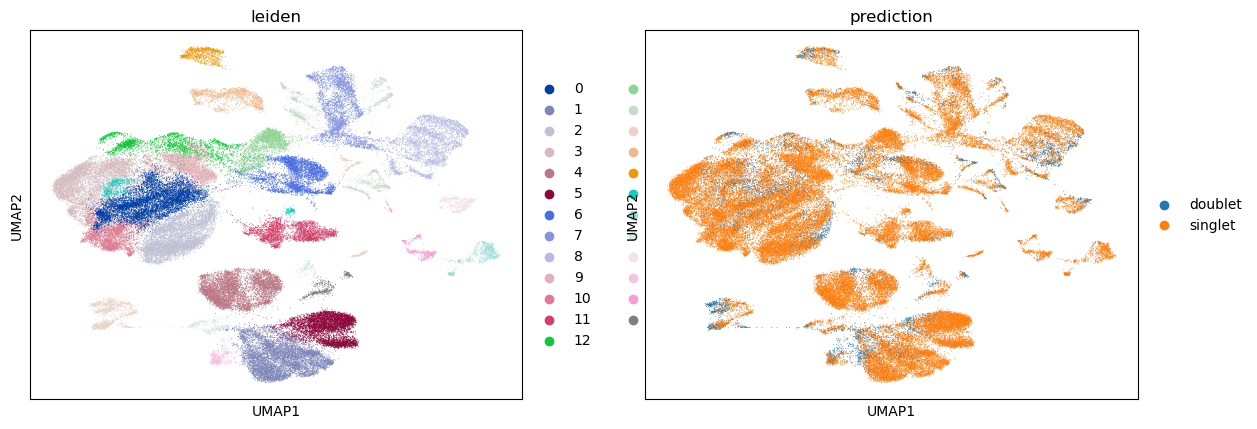

In [93]:
plot_doublets(adata_chen, df_chen)

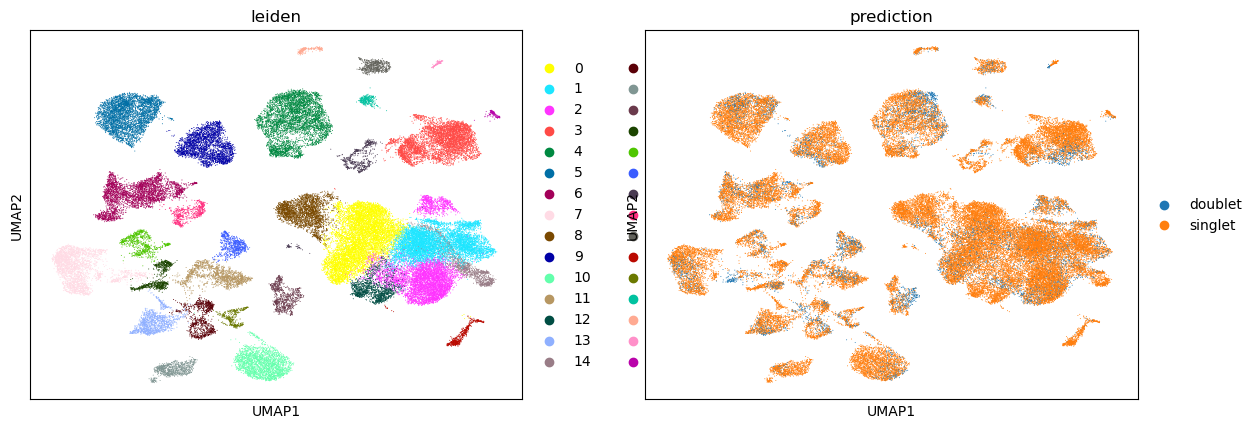

In [94]:
plot_doublets(adata_kurten, df_kurten)

In [96]:
doublet_chen = dict(zip(df_chen.index, df_chen.prediction))
doublet_kurten = dict(zip(df_kurten.index, df_kurten.prediction))

In [97]:
# save adata object

adata_chen.write_h5ad('adata_chen_01.h5ad')

In [99]:
# remove NA values

adata_kurten.uns['samples']['AJCC_stage'] = [
    str(x) if x is not None else 'NA' for x in adata_kurten.uns['samples']['AJCC_stage']
]


In [100]:
# save adata object

adata_kurten.write_h5ad('adata_kurten_01.h5ad')

In [101]:
# save scvi model

vae_chen.save("models/vae_chen_vae_model_01", overwrite=True)

In [102]:
# save adata object

vae_kurten.save("models/vae_kurten_vae_model_01", overwrite=True)

In [103]:
# save solo model

solo_chen.save("models/solo_chen_model_01", overwrite=True)

In [104]:
# save solo model

solo_kurten.save("models/solo_kurten_model_01", overwrite=True)

In [319]:
# re-load unprocessed data

adata_chen   = load_adata_from_directory(os.path.join(base_dir, "Data_Chen2020_Head-and-Neck"))
adata_kurten = load_adata_from_directory(os.path.join(base_dir, "Data_Kürten2021_Head-and-Neck"))

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [320]:
# re-format

adata_chen.obs.index = adata_chen.obs['cell_name']
adata_chen.obs.drop(columns='cell_name', inplace=True)

adata_kurten.obs.index = adata_kurten.obs['cell_name']
adata_kurten.obs.drop(columns='cell_name', inplace=True)

In [322]:
# format genes

adata_chen.var['gene_symbol'] = adata_chen.var['gene_symbol'].astype(str)
adata_chen.var_names = adata_chen.var['gene_symbol']
adata_chen.var_names_make_unique()

In [323]:
adata_chen.var = adata_chen.var.drop(columns='gene_symbol')

In [324]:
# format genes

adata_kurten.var['gene_symbol'] = adata_kurten.var['gene_symbol'].astype(str)
adata_kurten.var_names = adata_kurten.var['gene_symbol']
adata_kurten.var_names_make_unique()

In [325]:
adata_kurten.var = adata_kurten.var.drop(columns='gene_symbol')

In [326]:
# write function to label doublets in new AnnData objects

def label_dubs_chen(x):
    try:
        return doublet_chen[x]
    except:
        return 'filtered'

def label_dubs_kurten(x):
    try:
        return doublet_kurten[x]
    except:
        return 'filtered'

In [327]:
# label doublets

adata_chen.obs['doublet'] = adata_chen.obs.index.map(label_dubs_chen)
adata_kurten.obs['doublet'] = adata_kurten.obs.index.map(label_dubs_kurten)

In [328]:
adata_chen = adata_chen[adata_chen.obs.doublet == 'singlet']
adata_kurten = adata_kurten[adata_kurten.obs.doublet == 'singlet']

In [329]:
# remove NA values

adata_chen.uns['samples']['AJCC_stage'] = [
    str(x) if x is not None else 'NA' for x in adata_chen.uns['samples']['AJCC_stage']
]
adata_kurten.uns['samples']['AJCC_stage'] = [
    str(x) if x is not None else 'NA' for x in adata_kurten.uns['samples']['AJCC_stage']
]


In [330]:
# save doublet-filtered AnnData objects

adata_chen.write_h5ad('chen_no_doublets.h5ad')
adata_kurten.write_h5ad('kurten_no_doublets.h5ad')

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/anndata/_core/anndata.py:1145: Impli

In [313]:
# read in doublet-filtered adata objects

adata_chen = sc.read_h5ad('chen_no_doublets.h5ad')
adata_kurten = sc.read_h5ad('kurten_no_doublets.h5ad')

In [331]:
# label datasets of origin

adata_chen.obs['dataset'] = 'chen'
adata_kurten.obs['dataset'] = 'kurten'

## 2. Integrate datasets

In [332]:
# concatenate
adata = sc.concat([adata_chen, adata_kurten])

In [334]:
adata

AnnData object with n_obs × n_vars = 120018 × 31915
    obs: 'sample', 'cell_type', 'complexity', 'umap1', 'umap2', 'g1s_score', 'g2m_score', 'cell_cycle_phase', 'mp_top_score', 'mp_top', 'mp_assignment', 'doublet', 'dataset'

In [335]:
adata.obs_names_make_unique()

In [336]:
# save raw counts prior to integration
adata.layers["raw_counts"] = adata.X.copy()

In [337]:
# normalize and transform

sc.pp.normalize_total(adata, target_sum = 1e4)
sc.pp.log1p(adata)
adata.raw = adata

In [338]:
# scale to 3000 highly variable genes

sc.pp.highly_variable_genes(adata, n_top_genes=3000, subset = True,
                           flavor = "cell_ranger", batch_key="dataset")

In [343]:
# set up SCVI to integrate raw counts with dataset as a categorial covariate

scvi.model.SCVI.setup_anndata(adata, layer = 'raw_counts', categorical_covariate_keys=["dataset"])

In [348]:
model = scvi.model.SCVI(adata)

In [349]:
model

SCVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Not Trained
Model's adata is minified?: False

In [356]:
# train scvi

model.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 67/67: 100%|█| 67/67 [37:48<00:00, 34.38s/it, v_num=1, train_loss_step=492

`Trainer.fit` stopped: `max_epochs=67` reached.


Epoch 67/67: 100%|█| 67/67 [37:48<00:00, 33.86s/it, v_num=1, train_loss_step=492


In [357]:
# extract latent embeddings

latent = model.get_latent_representation()

In [358]:
latent.shape

(120018, 10)

In [359]:
# store latent features in adata

adata.obsm['X_scVI'] = latent

In [360]:
# retrieve denoised, normalized counts

adata.layers['scvi_normalized'] = model.get_normalized_expression(library_size = 1e4)

In [361]:
# compute nearest neighbors and UMAP embedding with leiden clustering

sc.pp.neighbors(adata, use_rep = 'X_scVI')
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution = 0.7)

Epoch 4/67:   4%| | 3/67 [1:41:45<36:10:50, 2035.16s/it, v_num=1, train_loss_ste
Epoch 1/67:   0%|                                        | 0/67 [39:25<?, ?it/s]


In [368]:
adata.obs.columns

Index(['sample', 'cell_type', 'complexity', 'umap1', 'umap2', 'g1s_score',
       'g2m_score', 'cell_cycle_phase', 'mp_top_score', 'mp_top',
       'mp_assignment', 'doublet', 'dataset', '_scvi_batch', '_scvi_labels',
       'leiden'],
      dtype='object')

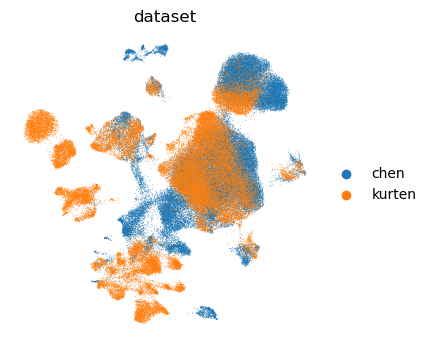

In [369]:
# visualize

with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(adata, color = ['dataset'], frameon = False)

In [ ]:
adata.write_h5ad('chen_kurten_integrated.h5ad')

## 3. Explore gene expression in malignant cells

In [4]:
# define gene sets

icb_res = [
    "PRSS27", "ELF3", "DESI1", "LTF", "PGLYRP4", "PDZK1IP1", "SPNS2", "PSCA", "PRSS22", "TMPRSS11G",
    "GSTO1", "KRT19", "MUC20", "TSPAN1", "DUOXA2", "TMEM242", "TMC5", "ECM1", "CBLC", "CCDC129", 
    "PRSS27P", "CAPN5", "GLRX", "SPNS3", "TMPRSS11E", "ZSCAN32", "TP53INP2", "SLC6A14", "DYNAP", 
    "DUSP4", "CLDN23", "CCDC69", "CLIC5", "GRPEL2", "APOL7B", "GDE1", "MAL", "DUOX2", "NUPR1", 
    "CLDN1", "P2RY2", "IRF7", "S100A14", "CDKN2B", "MALL", "PLEKHS1", "AC168977.1", "MUC4", "FXYD4", 
    "LY6G6D", "TRIM15", "MAL2", "WNT7B", "IFT22", "PLET1", "PPBP", "HIST1H1C", "CRYBA4", "KRT7", "HSD17B7", 
    "CLCA1", "TMPRSS11F", "SERPINB9", "CCDC186", "MYZAP", "SLC9A3R1", "PTTG1IP", "SLC28A3", "CIDEA", 
    "TMEM190", "PCDH11Y", "ARG1", "4930459C07RIK", "BSPRY", "CCDC12", "PIGR", "KRT23", "1810044K17RIK", 
    "CYP2D6", "PBP2", "CXCL5", "TMPRSS4", "LPCAT4", "CCDC71L", "ARHGAP27OS1", "EPS8L2", "TMPRSS11B", 
    "SERPINB9", "CSF3", "IFIT1", "LIPH", "EPHB3", "AA986860", "LGALS3", "RASSF7", "GRHL1", 
    "GFPT1", "TRIM16", "SPRR2D"
]

ifn_resp = [
    "GBP6", "GBP2", "IIGP1", "CNTN1", "TMEM226", "OR56A4", "MILL1", "CXCL10", "GBP4", "IFIT3", 
    "APOL10", "IFI47", "GBP5", "SLCO2A1", "PRL", "GREB1L", "GBP8", "CCL7", "TMEM121", "ZBED2", 
    "APOL9", "GPR176", "ADGRB3", "PRL", "CCL2", "RGS4", "IFIT1", "SERPINA3", "IRF1", "ASIC2", 
    "CXCL9", "MS4A4A", "IFIH1", "ZBTB8B", "ALOX12", "NRG1", "GHR", "GRIN2D", "CLIC4", "ROBO2", 
    "CCDC166", "LAMA3", "FAM126A", "ERLIN2", "GNB4", "AMMECR1", "ZC3H12C", "PRL", "SAMD5", 
    "FCGBP", "PLCB1", "FLNB", "CYP7B1", "IL24", "ALOX15", "IFIT3", "NCAM1", "CSPR2", "CD44", 
    "IL18R1", "SERPINB2", "EFEMP1", "TENM1", "CCL8", "SLC6A4", "HAS2", "UBD", "NPPB", "CCL11", 
    "FAP", "PCDH7", "IGFN1", "IFI16", "TNC", "MAJIN", "CSMD1", "ROBO1", "VCAM1", "IRF7", 
    "ZC3H12A", "NPAS3", "ITGB6", "DCLK1", "NEK10", "LY75", "CFAP47", "SLC4A7", "VEGFC", 
    "CNGA1", "HCN1", "SYT1", "SLCO1A2", "GDNF", "TENM3", "ERC1", "SKINT3", "PDLIM1", 
    "DNAH8", "CSNK1G3", "TNIP3"
]

In [2]:
# read in integrated adata object

adata = sc.read_h5ad('/path/to/chen_kurten_integrated.h5ad')

In [5]:
# score gene sets

sc.tl.score_genes(adata, gene_list=icb_res, score_name='ICB_RES')
sc.tl.score_genes(adata, gene_list=ifn_resp, score_name='IFN_RESP')

       '4930459C07RIK', '1810044K17RIK', 'PBP2', 'ARHGAP27OS1', 'AA986860'],
      dtype='object')
       'CSPR2', 'SKINT3'],
      dtype='object')


In [6]:
# 1. compute per-sample mean ICB_RES score
sample_scores = adata.obs.groupby("sample")["IFN_RESP"].mean()

# 2. define ICB-res-high vs. -low samples by mean split
threshold = sample_scores.mean()
sample_labels = sample_scores.apply(lambda x: "IFNRESP_high" if x > threshold else "IFNRESP_low")

# 3. map ICB-res classification back to each cell in adata.obs
adata.obs["IFNRESP_class"] = adata.obs["sample"].map(sample_labels)


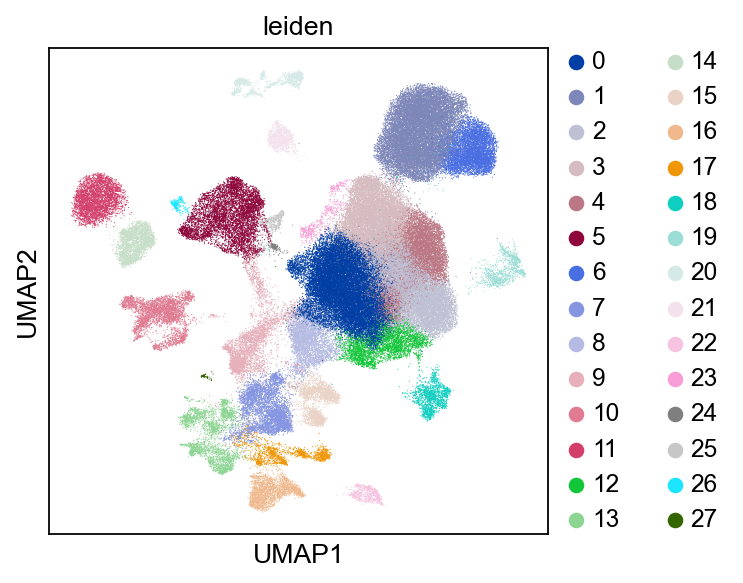

In [9]:
sc.pl.umap(adata, color = 'leiden')

In [7]:
# identify and remove undefined cell types
leiden_to_remove = ['9','8','20']
adata_filt = adata[~adata.obs['leiden'].isin(leiden_to_remove)]

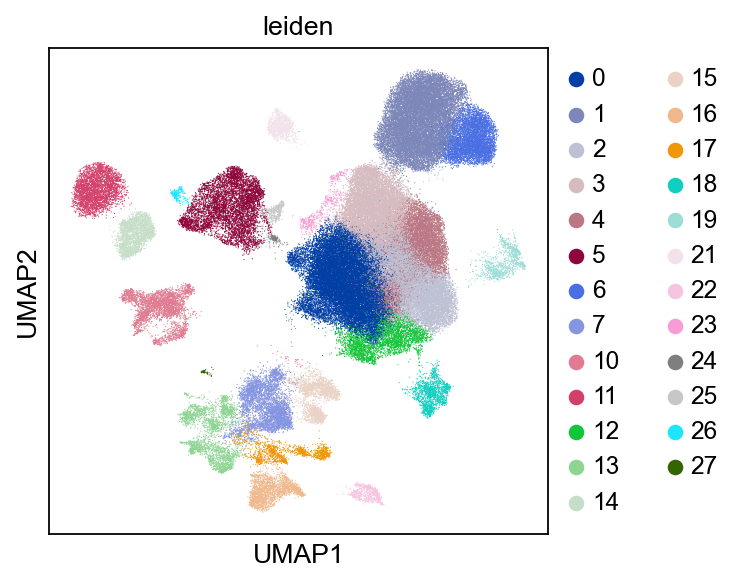

In [16]:
sc.pl.umap(adata_filt, color = 'leiden')

In [8]:
sample_labels.value_counts()

IFN_RESP
IFNRESP_low     27
IFNRESP_high    20
Name: count, dtype: int64

In [9]:
# restrict to maligant cells and remove cells with incorrect celltype assignments
adata_filt_malig = adata_filt[adata_filt.obs['cell_type']=='Malignant']
adata_filt_malig = adata_filt_malig[~adata_filt_malig.obs['leiden'].isin(['5','10','4','3','12'])]

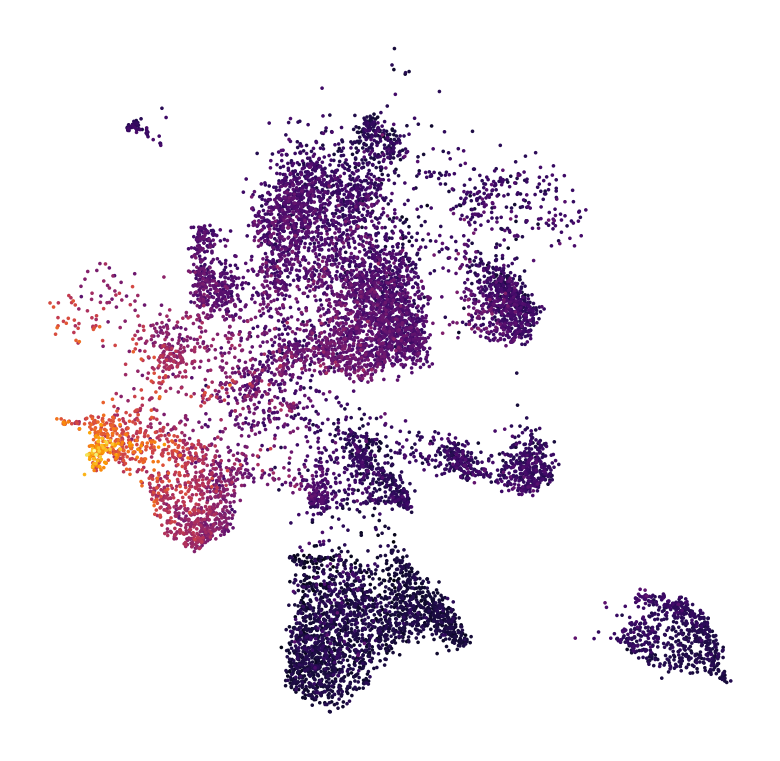

In [31]:
with rc_context({'figure.figsize': (6, 6)}):
    sc.pl.umap(adata_filt_malig, color = 'ICB_RES',frameon = False,
               color_map = 'inferno', legend_loc='none', title='',
               colorbar_loc=None)

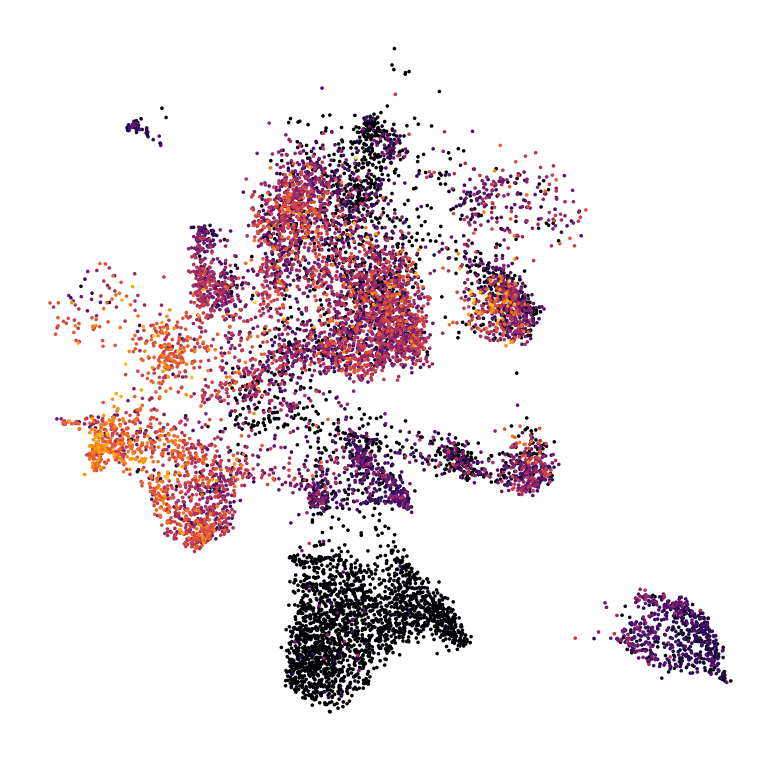

In [32]:
with rc_context({'figure.figsize': (6, 6)}):
    sc.pl.umap(adata_filt_malig, color = 'ELF3',frameon = False,
               color_map = 'inferno', legend_loc='none', title='',
               colorbar_loc=None)

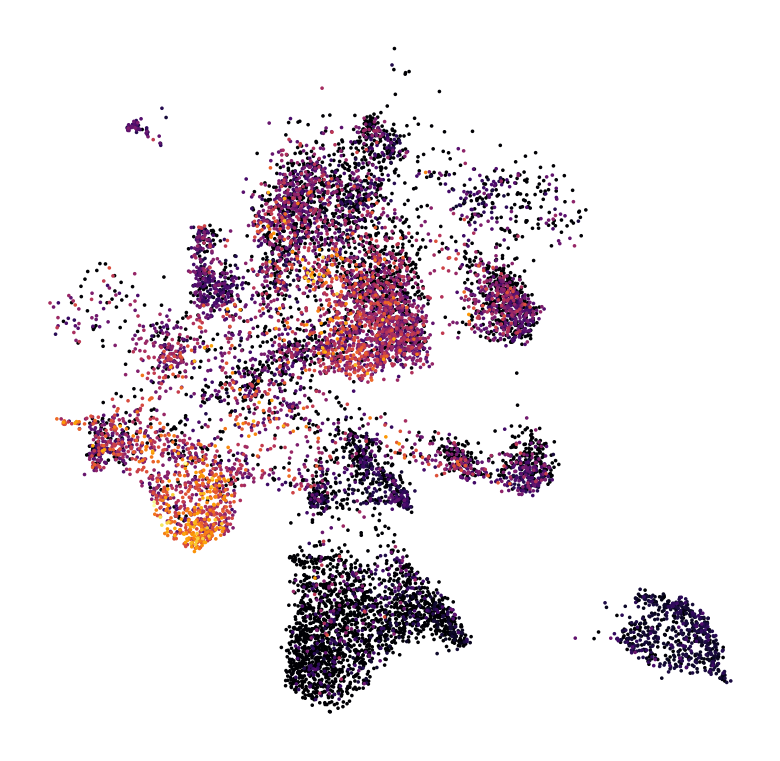

In [33]:
with rc_context({'figure.figsize': (6, 6)}):
    sc.pl.umap(adata_filt_malig, color = 'MAL2',frameon = False,
               color_map = 'inferno', legend_loc='none', title='',
               colorbar_loc=None)

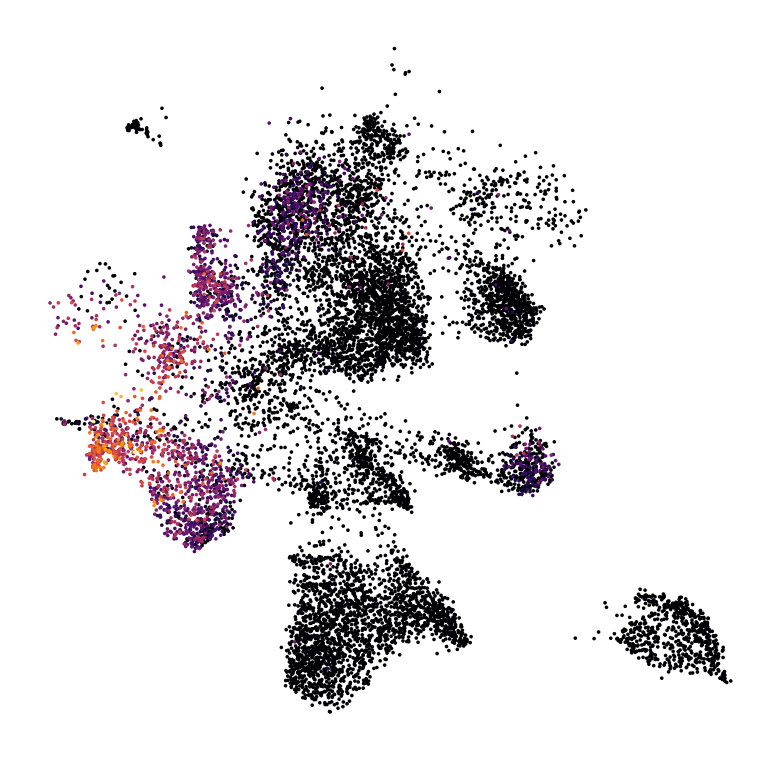

In [34]:
with rc_context({'figure.figsize': (6, 6)}):
    sc.pl.umap(adata_filt_malig, color = 'MUC4',frameon = False,
               color_map = 'inferno', legend_loc='none', title='',
               colorbar_loc=None)

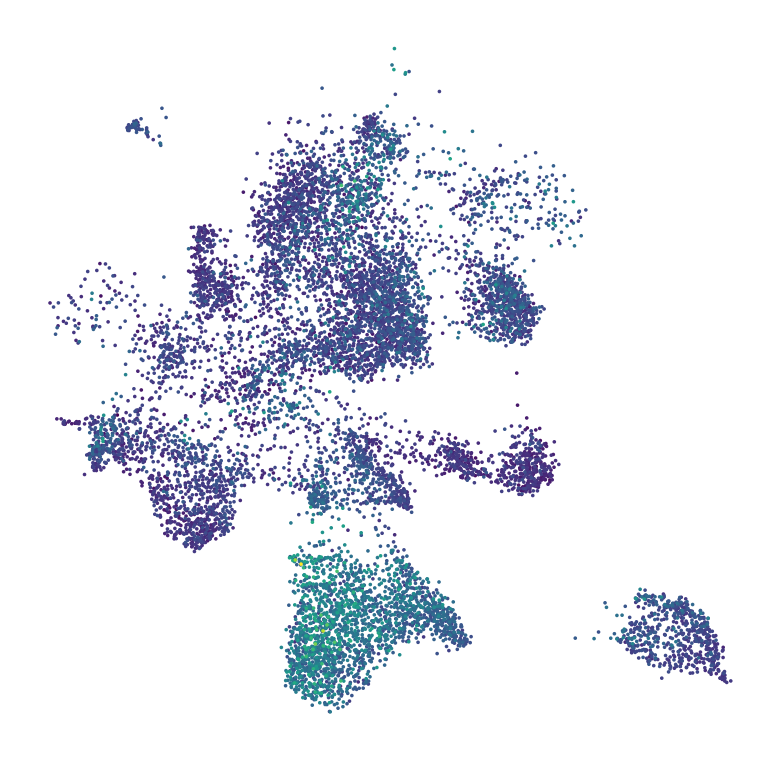

In [25]:
with rc_context({'figure.figsize': (6, 6)}):
    sc.pl.umap(adata_filt_malig, color = 'IFN_RESP',frameon = False, color_map = 'viridis',
               legend_loc='none', title='',colorbar_loc=None)

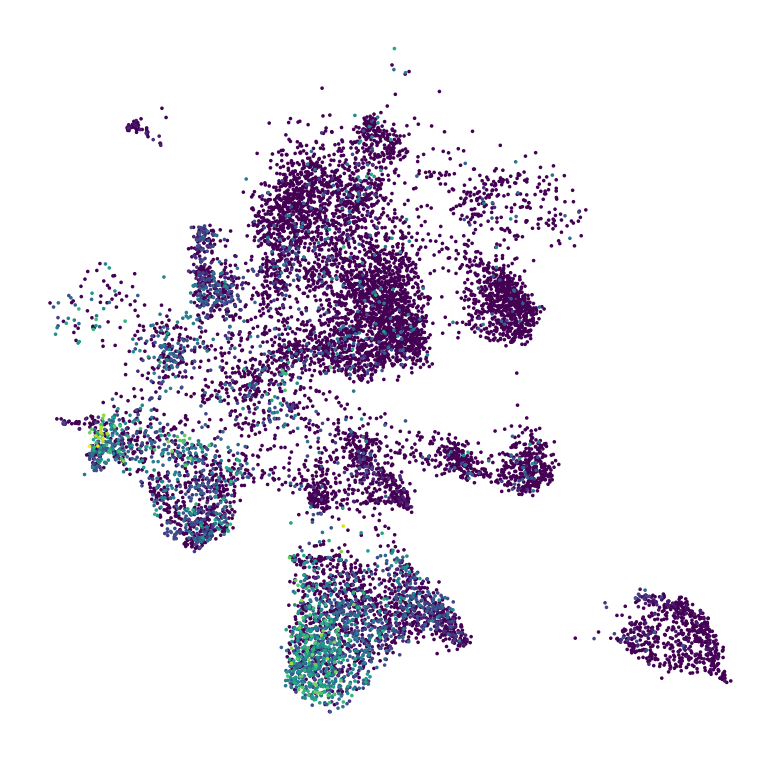

In [43]:
with rc_context({'figure.figsize': (6, 6)}):
    sc.pl.umap(adata_filt_malig, color = 'GBP2',frameon = False, 
               color_map = 'viridis',legend_loc='none', 
               title='',colorbar_loc=None, save = 'GBP2.png')

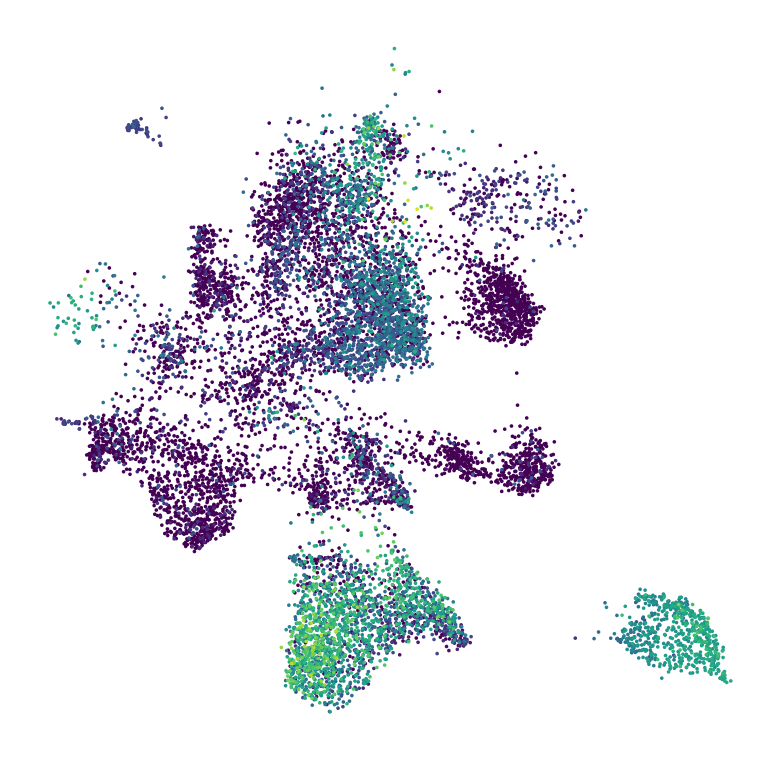

In [44]:
with rc_context({'figure.figsize': (6, 6)}):
    sc.pl.umap(adata_filt_malig, color = 'HLA-DRA',frameon = False, 
               color_map = 'viridis',legend_loc='none', title='',
               colorbar_loc=None, save = 'HLADRA.png')

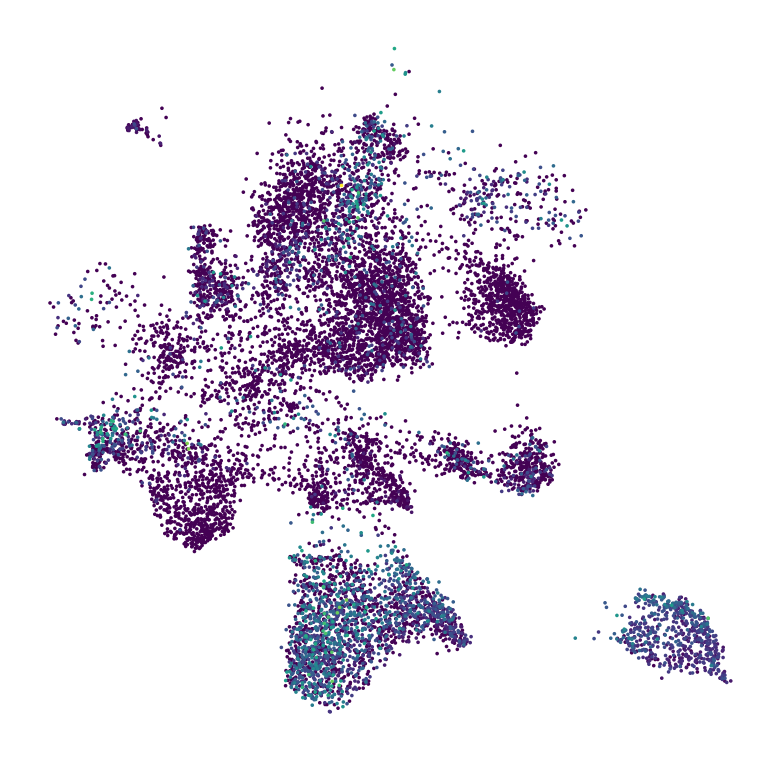

In [36]:
with rc_context({'figure.figsize': (6, 6)}):
    sc.pl.umap(adata_filt_malig, color = 'IFIT3',frameon = False, 
               color_map = 'viridis',legend_loc='none', title='',
               colorbar_loc=None)

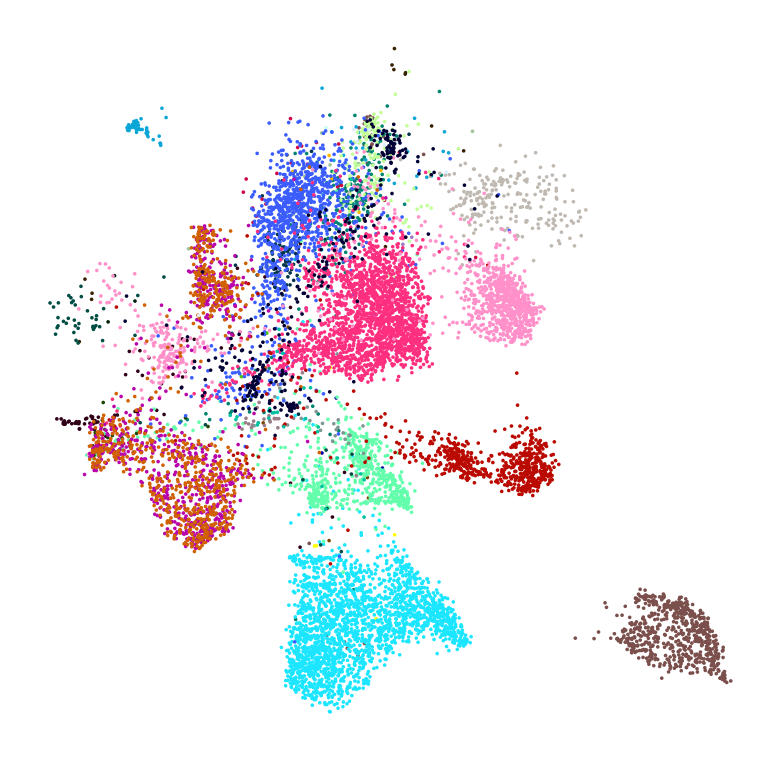

In [37]:
# Define your color mapping
palette = {
    "ICBRES_high": "crimson",
    "ICBRES_low": "limegreen"
}

with rc_context({'figure.figsize': (6, 6)}):
    sc.pl.umap(
        adata_filt_malig,
        color='sample',
        #palette=palette,
        frameon=False,
        legend_loc=None,   # no legend
        title='',
    )


## 4. Plot chemokine expression

In [41]:
# compute per-sample ICB resistance scores
sample_scores = (
    adata.obs[["sample", "ICB_RES"]]
    .dropna()
    .drop_duplicates(subset="sample", keep="first")  # ensure uniqueness
    .set_index("sample")
)

# calculate thresholds for top and bottom by median split
top_thresh = sample_scores["ICB_RES"].quantile(0.5) # higher quantile
bot_thresh = sample_scores["ICB_RES"].quantile(0.5) # lower quantile

# create top/bottom 10% labels ("extremes")
sample_scores["ICBRES_extreme"] = "middle"
sample_scores.loc[sample_scores["ICB_RES"] >= top_thresh, "ICBRES_extreme"] = "ICBRES_high"
sample_scores.loc[sample_scores["ICB_RES"] <= bot_thresh, "ICBRES_extreme"] = "ICBRES_low"

# map back to adata
adata_filt_malig.obs["ICBRES_extreme"] = adata_filt_malig.obs["sample"].map(sample_scores["ICBRES_extreme"])
adata_filt_malig.obs["ICBRES_extreme"] = adata_filt_malig.obs["sample"].map(sample_scores["ICBRES_extreme"])


In [54]:
# create function to plot heatmap for select genes (by median split)

def plot_icbres_heatmap_per_sample(
    adata,
    genes,
    cell_type=None,
    groupby_sample="sample",
    groupby_class="ICBRES_class",
    use_raw=True,
    zscore=True,
    save_path=None,
    dpi=None
):

    # subset by cell type
    if cell_type is not None:
        adata = adata[adata.obs["cell_type"] == cell_type].copy()

    # extract expression
    if use_raw:
        X = adata.raw[:, genes].X
    else:
        missing = [g for g in genes if g not in adata.var_names]
        if missing:
            raise ValueError(f"Missing genes: {missing}")
        X = adata[:, genes].X

    X = X.toarray() if hasattr(X, "toarray") else X

    # build dataframe for heatmap
    df_expr = pd.DataFrame(X, columns=genes, index=adata.obs_names)
    df_expr[groupby_sample] = adata.obs[groupby_sample].values

    # average scores as pseudobulk per sample
    df_avg = df_expr.groupby(groupby_sample).mean().T  # genes x samples

    # get ICB-res class for each sample and order
    sample_class = (
        adata.obs[[groupby_sample, groupby_class]]
        .drop_duplicates()
        .set_index(groupby_sample)
        .loc[df_avg.columns]
    )

    df_avg.columns.name = "sample"
    df_avg = df_avg.loc[:, sample_class.sort_values(by=groupby_class).index]
    sample_class = sample_class.loc[df_avg.columns]

    # Z-score
    if zscore:
        df_avg = df_avg.apply(lambda x: (x - x.mean()) / x.std(), axis=1)

    # 5. plot heatmap
    lut = {"ICBRES_high": "darkorange", "ICBRES_low": "navy"}
    col_colors = sample_class[groupby_class].map(lut)

    sns.clustermap(
        df_avg,
        cmap='coolwarm',
        col_colors=col_colors,
        col_cluster=False,
        row_cluster=False,
        xticklabels=False,
        yticklabels=True,
        vmin=-1,
        vmax=1,
        center=0,
        figsize=(0.3 * df_avg.shape[1] + 2, 0.4 * df_avg.shape[0] + 1),
        cbar_kws={"label": "Z-score"},
        linecolor=None
    )
    

    if save_path:
        plt.savefig(save_path, dpi=dpi)
    plt.show()


In [11]:
# compute per-sample cell counts
sample_counts = adata_filt_malig.obs["sample"].value_counts()

# only keep samples that have at least 12 cells
good_samples = sample_counts[sample_counts >= 12].index.tolist()

# subset AnnData to only those samples
adata_sub = adata_filt_malig[adata_filt_malig.obs["sample"].isin(good_samples)].copy()


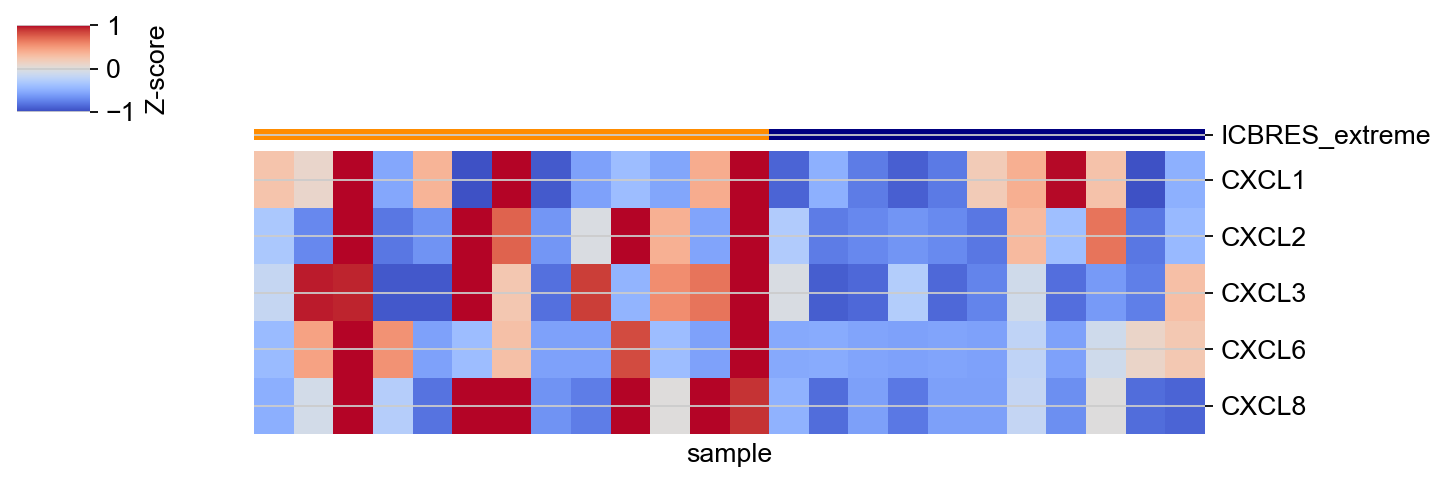

In [56]:
genes = ["CXCL1","CXCL2","CXCL3","CXCL6","CXCL8"]

plot_icbres_heatmap_per_sample(
    adata=adata_sub[adata_sub.obs['ICBRES_extreme']!='middle'],
    genes=genes,
    cell_type="Malignant",
    groupby_sample="sample",
    groupby_class="ICBRES_extreme",
    use_raw=True,
    zscore=True,
)

## 5. Plot IFN-response and ICB-resistance scores

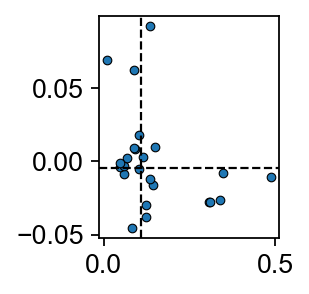

In [29]:
# compute per‐sample ICB-resistance means
sample_means = (
    adata_sub.obs
    .groupby("sample")[["ICB_RES", "IFN_RESP"]]
    .mean()
    .reset_index()
)

# compute medians
med_icb = sample_means["ICB_RES"].median()
med_ifn = sample_means["IFN_RESP"].median()

# scatter plot (ICB-resistance on x-axis, IFN-response on y-axis)
plt.figure(figsize=(2,2))
sns.scatterplot(
    data=sample_means,
    x="ICB_RES",
    y="IFN_RESP",
    s=15,
    color="tab:blue",
    edgecolor="black",
    linewidth=0.5
)

# add median lines
plt.axvline(med_icb, color="black", linestyle="--", linewidth=1, label=f"ICB_RES median ({med_icb:.2f})")
plt.axhline(med_ifn, color="black", linestyle="--", linewidth=1, label=f"IFN_RESP median ({med_ifn:.2f})")

# format
plt.xlabel("")
plt.ylabel("")
plt.title("")
plt.legend().remove()
plt.grid(False)
plt.tight_layout()

plt.show()